# Load data

<https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Feature names
columns = [
    'Checking Status', 'Duration', 'Credit History', 'Purpose',
    'Credit Amount', 'Savings Account/Bonds', 'Employment Since',
    'Installment Rate', 'Personal Status', 'Debtors/Guarantors',
    'Residence Duration', 'Property Type', 'Age',
    'Other Installment Plans', 'Housing Ownership',
    'Number Existing Credits', 'Job', 'Number Liable', 'Telephone',
    'Foreign Worker', 'Good Customer'
]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [columns.index(col) for col in categorical_columns]

# Load data
df = pd.read_table('../data/SouthGermanCredit.asc', sep=' ', header=None,
                  index_col=None, names=columns, skiprows=1)

# Names
feature_names = columns[:-1]

In [3]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

# Train model

In [4]:
import numpy as np
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier

In [5]:
model = CatBoostClassifier(iterations=50,
                           learning_rate=0.3,
                           depth=3)

model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val),
                  verbose=False)

In [6]:
# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


# Calculate feature importance

In [7]:
import sage

In [8]:
# Setup and calculate
imputer = sage.MarginalImputer(train[:512])
sampler = sage.PermutationSampler(model, imputer, 'cross entropy')
sage_values = sampler(test, Y_test)

Estimating convergence time
Batch size = batch * samples = 262144


StdDev Ratio = 0.0873 (Converge at 0.0500)
StdDev Ratio = 0.0695 (Converge at 0.0500)
StdDev Ratio = 0.0548 (Converge at 0.0500)
StdDev Ratio = 0.0466 (Converge at 0.0500)
Detected convergence



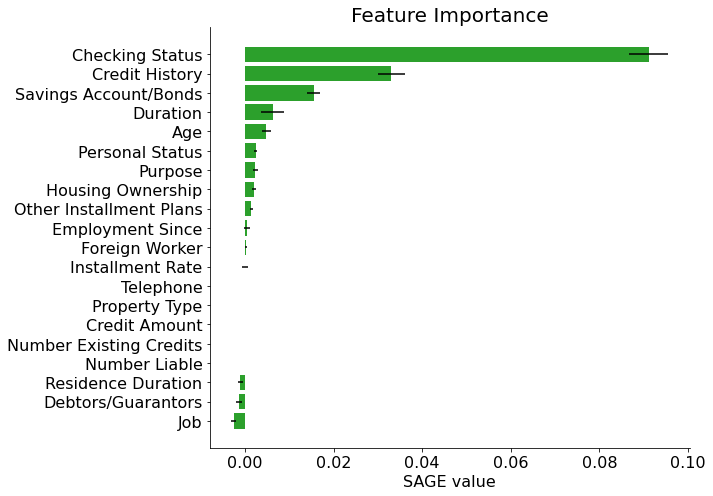

In [9]:
# Plot results
sage_values.plot(feature_names)

# Calculate model sensitivity (no labels)

In [10]:
# Setup and calculate
imputer = sage.MarginalImputer(train[:512])
sampler = sage.PermutationSampler(model, imputer, 'cross entropy')
sensitivity = sampler(test)

Using model output to calculate sensitivity
Estimating convergence time
Batch size = batch * samples = 262144


StdDev Ratio = 0.0420 (Converge at 0.0500)
Detected convergence



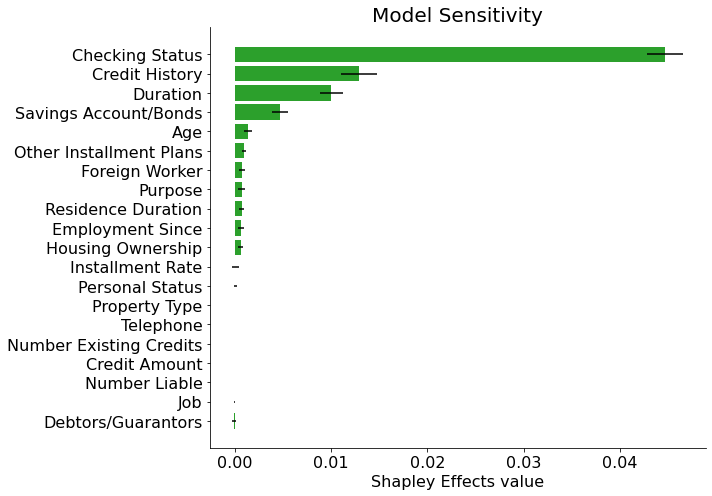

In [11]:
# Plot results
sensitivity.plot(feature_names, title='Model Sensitivity')